# Train YOLO for Object Detection

1) Environment Setup
2) GPU Check
3) Configure Project & Dataset paths 
4) Dataset Layout
    - 4.1) Check Images Pairing
    - 4.2) Convert XML to TXT (Optional)
5) Quick Visualization of Labels
6) Train YOLO 
7) Evaluate on Validation Set
8) Predict on Sample Images
9) Export Model to ONNX (Optional)
10) Real-Time Predictions

## 1) Environment Setup

In [ ]:

# If running locally, uncomment to install
# Note: Restart the kernel after installing.
# !pip install --upgrade pip
# !pip install ultralytics opencv-python pyyaml matplotlib tqdm pillow

import os, sys, json, random, shutil, glob, math
from pathlib import Path
import yaml
import numpy as np
import matplotlib.pyplot as plt
print("Python", sys.version)

Python 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


## 2) GPU Check

In [2]:

try:
    import torch
    print("Torch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("CUDA device:", torch.cuda.get_device_name(0))
except Exception as e:
    print("Torch not found or no GPU. That's okay for CPU training, just slower.")


Torch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 2060 SUPER


## 3) Configure Project & Dataset paths

In [4]:

# === EDIT THESE FOR YOUR SETUP ===
# Base dataset folder following YOLO layout:
# images/{train,val,test} and labels/{train,val,test}
DATA_ROOT = Path("data")                   # change to your dataset root
IMAGES_DIR = DATA_ROOT / "images"
LABELS_DIR = DATA_ROOT / "labels"

# Class names in order (index = class id).
# Example for 2 classes:
# NAMES = ["person", "car"]
NAMES = ["person", "car", "bicycle", "airplane", "dog", "chair", "bus"] # Edit this

# Where to write data.yaml and save results
CONFIGS_DIR = Path("configs"); CONFIGS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR = Path("results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Images dir:", IMAGES_DIR.resolve())
print("Labels dir:", LABELS_DIR.resolve())
print("Configs dir:", CONFIGS_DIR.resolve())
print("Results dir:", RESULTS_DIR.resolve())


Images dir: E:\my_project\Object Detection\data\images
Labels dir: E:\my_project\Object Detection\data\labels
Configs dir: E:\my_project\Object Detection\configs
Results dir: E:\my_project\Object Detection\results



## 4) Dataset layout
Expected Structure
```
data/
├─ images/
│  ├─ train/
│  └─ val/
└─ labels/
   ├─ train/
   └─ val/

```


In [12]:

def count_files(folder: Path, exts=(".jpg", ".jpeg", ".png")):
    return sum(1 for p in folder.rglob("*") if p.suffix.lower() in exts)

splits = ["train", "val", "test"]
for s in splits:
    img_dir = IMAGES_DIR / s
    lbl_dir = LABELS_DIR / s
    imgs = list(img_dir.glob("*.*")) if img_dir.exists() else []
    lbls = list(lbl_dir.glob("*.txt")) if lbl_dir.exists() else []
    print(f"[{s}] images: {len(imgs):4d} | labels: {len(lbls):4d} | img_dir: {img_dir.exists()} | lbl_dir: {lbl_dir.exists()}")


[train] images:   38 | labels:   38 | img_dir: True | lbl_dir: True
[val] images:   14 | labels:   14 | img_dir: True | lbl_dir: True
[test] images:    0 | labels:    0 | img_dir: False | lbl_dir: False


### 4.1) Check Images Pairing

In [13]:

def image_label_mismatches(split="train"):
    img_dir = IMAGES_DIR / split
    lbl_dir = LABELS_DIR / split
    imgs = {p.stem for p in img_dir.glob("*.*")}
    lbls = {p.stem for p in lbl_dir.glob("*.txt")}
    only_imgs = sorted(list(imgs - lbls))[:20]
    only_lbls = sorted(list(lbls - imgs))[:20]
    return only_imgs, only_lbls

for s in ["train", "val"]:
    only_imgs, only_lbls = image_label_mismatches(s)
    print(f"[{s}] no-label images (showing up to 20):", only_imgs)
    print(f"[{s}] orphan labels (showing up to 20):", only_lbls)


[train] no-label images (showing up to 20): []
[train] orphan labels (showing up to 20): []
[val] no-label images (showing up to 20): []
[val] orphan labels (showing up to 20): []


### 4.2) Convert XML to TXT (Optional)

In [14]:

# If your annotations are in Pascal VOC XML, you can convert them here.
# Set VOC_ANN_DIR to the folder containing .xml files and IMG_DIR to matching images.
# This writes YOLO .txt files into LABELS_DIR/<split>/

from xml.etree import ElementTree as ET

VOC_ANN_DIR = Path("data/annotations_xml")   # <<< EDIT if needed
SPLIT_FOR_VOC = "train"                      # "train" or "val" or "test"
IMG_DIR_FOR_VOC = IMAGES_DIR / SPLIT_FOR_VOC
OUT_LABEL_DIR = LABELS_DIR / SPLIT_FOR_VOC
OUT_LABEL_DIR.mkdir(parents=True, exist_ok=True)

def voc_to_yolo_box(img_w, img_h, xmin, ymin, xmax, ymax):
    x_c = (xmin + xmax) / 2.0 / img_w
    y_c = (ymin + ymax) / 2.0 / img_h
    w = (xmax - xmin) / img_w
    h = (ymax - ymin) / img_h
    return x_c, y_c, w, h

def convert_voc_dir():
    xmls = list(VOC_ANN_DIR.glob("*.xml"))
    print("Found XML:", len(xmls), "→ writing YOLO labels to", OUT_LABEL_DIR)
    for xml_path in xmls:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        filename_node = root.find("filename")
        if filename_node is None:
            continue
        img_name = filename_node.text
        img_path = IMG_DIR_FOR_VOC / img_name
        # fetch image size
        size = root.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        yolo_lines = []
        for obj in root.findall("object"):
            cls_name = obj.find("name").text.strip()
            if cls_name not in NAMES:
                # Skip unknown classes; you can also choose to add dynamically
                continue
            cls_id = NAMES.index(cls_name)
            bnd = obj.find("bndbox")
            xmin, ymin = int(float(bnd.find("xmin").text)), int(float(bnd.find("ymin").text))
            xmax, ymax = int(float(bnd.find("xmax").text)), int(float(bnd.find("ymax").text))
            x_c, y_c, w_n, h_n = voc_to_yolo_box(w, h, xmin, ymin, xmax, ymax)
            yolo_lines.append(f"{cls_id} {x_c:.6f} {y_c:.6f} {w_n:.6f} {h_n:.6f}")

        # write label file
        out_txt = OUT_LABEL_DIR / (Path(img_name).stem + ".txt")
        with open(out_txt, "w") as f:
            f.write("\n".join(yolo_lines))
    print("Done VOC → YOLO conversion.")

# Run only if you actually need conversion
# convert_voc_dir()


In [15]:

data_yaml = {
    "path": str(DATA_ROOT.resolve()),
    "train": str((IMAGES_DIR / "train").resolve()),
    "val":   str((IMAGES_DIR / "val").resolve()),
    "test":  str((IMAGES_DIR / "test").resolve()) if (IMAGES_DIR/"test").exists() else "",
    "names": NAMES,
    "nc": len(NAMES),
}
yaml_path = CONFIGS_DIR / "data.yaml"
with open(yaml_path, "w") as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)
print("Wrote", yaml_path.resolve())
print(yaml.safe_dump(data_yaml, sort_keys=False))


Wrote E:\my_project\Object Detection\configs\data.yaml
path: E:\my_project\Object Detection\data
train: E:\my_project\Object Detection\data\images\train
val: E:\my_project\Object Detection\data\images\val
test: ''
names:
- person
- car
- bicycle
- airplane
- dog
- chair
- bus
nc: 7



## 5) Quick Visualization of Labels

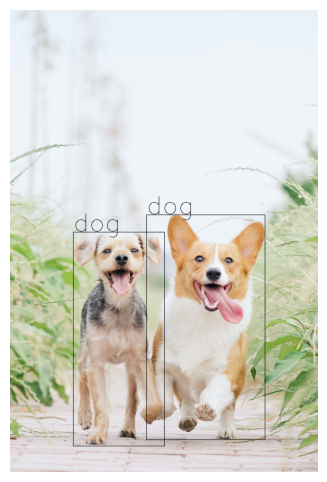

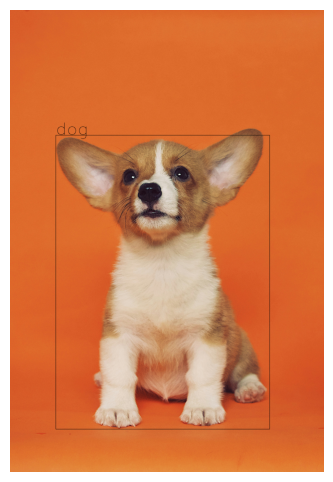

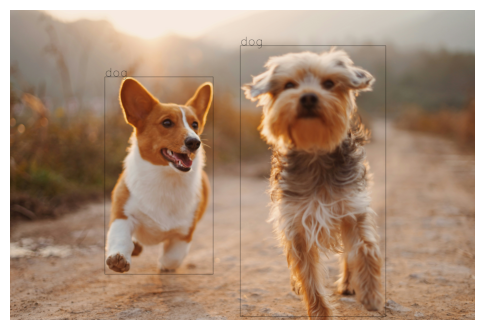

In [16]:

import cv2
from random import sample

def load_yolo_labels(txt_file):
    boxes = []
    if not txt_file.exists():
        return boxes
    for line in txt_file.read_text().strip().splitlines():
        cid, x, y, w, h = line.split()
        boxes.append((int(cid), float(x), float(y), float(w), float(h)))
    return boxes

def plot_image_with_boxes(img_path, labels_path, class_names):
    img = cv2.imread(str(img_path))
    if img is None:
        print("Could not read:", img_path)
        return
    h, w = img.shape[:2]
    boxes = load_yolo_labels(labels_path)
    for (cid, xc, yc, bw, bh) in boxes:
        x1 = int((xc - bw/2) * w)
        y1 = int((yc - bh/2) * h)
        x2 = int((xc + bw/2) * w)
        y2 = int((yc + bh/2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 0), 2)
        label = class_names[cid] if 0 <= cid < len(class_names) else str(cid)
        cv2.putText(img, f"{label}", (x1, max(0,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 0), 2)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

# Show a few from train
train_imgs = list((IMAGES_DIR/"train").glob("*.*"))
for p in train_imgs[:3]:
    plot_image_with_boxes(p, (LABELS_DIR/"train"/(p.stem + ".txt")), NAMES)


## 6) Train YOLO

In [20]:

from ultralytics import YOLO

# Choose a starting model: yolov8n.pt (nano), yolov8s.pt, yolov8m.pt, yolov8l.pt
MODEL_NAME = "yolov8s.pt"   # small & fast to start
EPOCHS = 200
IMGSZ = 640
BATCH = -1   # auto
PROJECT = str(RESULTS_DIR)
RUN_NAME = None  # or set to a string

model = YOLO("yolov8s.pt")

results = model.train(
    data="configs/data.yaml",
    epochs=200,
    imgsz=640,
    batch=-1,
    project="results",
    name="train_aug",
    pretrained=True,

    # augmentation args go here
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10.0,
    translate=0.10,
    scale=0.70,
    shear=2.0,
    perspective=0.0005,
    flipud=0.0,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.2,
    close_mosaic=10
)

New https://pypi.org/project/ultralytics/8.3.179 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.176  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=configs/data.yaml, degrees=10.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_aug, nbs=64, nms=False, opset=None, o

train: Scanning E:\my_project\Object Detection\data\labels\train... 38 images, 2 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<00:00, 477.23it/s]

train: New cache created: E:\my_project\Object Detection\data\labels\train.cache
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (NVIDIA GeForce RTX 2060 SUPER) 8.00G total, 0.13G reserved, 0.12G allocated, 7.75G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output


    11138309       28.66         0.826         165.1         840.3        (1, 3, 640, 640)                    list
    11138309       57.32         1.120         17.95         163.6        (2, 3, 640, 640)                    list
    11138309       114.6         1.640         33.94         69.62        (4, 3, 640, 640)                    list
    11138309       229.3         2.615         47.87         89.29        (8, 3, 640, 640)                    list
    11138309       458.6         4.651         76.77         138.5       (16, 3, 640, 640)                    list
AutoBatch: Using batch-size 17 for CUDA:0 5.16G/8.00G (64%) 
train: Fast image access  (ping: 0.10.0 ms, read: 2153.5520.6 MB/s, size: 8400.4 KB)


train: Scanning E:\my_project\Object Detection\data\labels\train.cache... 38 images, 2 backgrounds, 0 corrupt: 100%|██████████| 38/38 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 1369.5847.8 MB/s, size: 8779.4 KB)


val: Scanning E:\my_project\Object Detection\data\labels\val... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<00:00, 877.30it/s]

val: New cache created: E:\my_project\Object Detection\data\labels\val.cache


Plotting labels to results\train_aug\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00053125), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to results\train_aug
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      3.91G      1.445      7.407      1.721         17        640: 100%|██████████| 3/3 [00:07<00:00,  2.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

                   all         14         32      0.544      0.154      0.199      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      3.91G      1.412       6.49       1.48         18        640: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         14         32      0.543      0.154      0.199      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      3.91G      1.501      9.125      1.586         11        640: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]

                   all         14         32      0.539      0.161      0.253      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      3.91G       1.34      3.039       1.46         17        640: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         14         32      0.643      0.746      0.763      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      3.91G      1.327      2.405      1.507         11        640: 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         14         32      0.774      0.781      0.818       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      3.91G      1.505      2.001       1.45         18        640: 100%|██████████| 3/3 [00:00<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         14         32      0.773       0.79      0.857      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      3.91G       1.12      1.815      1.297         10        640: 100%|██████████| 3/3 [00:00<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         14         32      0.755      0.909      0.904       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      3.91G      1.151      1.832      1.277         12        640: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         14         32      0.882      0.878       0.95      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.91G      1.234      1.728      1.476          8        640: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         14         32      0.783      0.974      0.951      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      3.91G      1.229      1.428      1.265         30        640: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         14         32      0.889      0.909      0.969      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      3.91G       1.32      1.416      1.319         38        640: 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         14         32      0.888      0.916      0.942      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      3.91G      1.162      1.401      1.223         23        640: 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         14         32      0.854      0.909      0.931      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.91G      1.249      1.432      1.334         13        640: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         14         32       0.95      0.898       0.97      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      3.91G       1.28      1.332      1.279         30        640: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all         14         32      0.956      0.906      0.988      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      3.91G      1.186      1.188      1.369         12        640: 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         14         32      0.886      0.951      0.988      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      3.91G      1.225      1.284      1.393         16        640: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         14         32      0.912      0.943      0.982      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.91G      1.074      1.104      1.196         15        640: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.28it/s]

                   all         14         32       0.88      0.929      0.964      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      3.91G      1.223      1.322       1.29         26        640: 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


                   all         14         32      0.825      0.915      0.964      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.91G      1.161      1.185      1.344         24        640: 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         14         32      0.706       0.95      0.885      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.91G      1.302      1.246      1.303         28        640: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         14         32      0.655          1      0.867      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.91G      1.169      1.136       1.22         22        640: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


                   all         14         32      0.707          1      0.881      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      3.91G      1.255      1.238      1.379         17        640: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         14         32      0.811      0.857      0.895      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      3.91G      1.151      1.107      1.232         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         14         32      0.775       0.88      0.898      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.91G      1.209      1.176      1.353         20        640: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         14         32      0.822      0.898      0.894      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      3.91G       1.07      1.109      1.212         24        640: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]

                   all         14         32      0.768      0.951      0.825      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.91G      1.305      1.318      1.316         35        640: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         14         32      0.745      0.921      0.792      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      3.91G      1.202      1.183      1.417         20        640: 100%|██████████| 3/3 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         14         32      0.816      0.922      0.959      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      3.91G      1.076     0.9703      1.229         21        640: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         14         32        0.9      0.905      0.963      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.91G      1.262      1.159      1.322         34        640: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         14         32      0.873       0.85      0.917      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      3.91G      1.186      1.217      1.268         11        640: 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         14         32       0.85      0.853      0.898      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      3.91G      1.205      1.123      1.316         18        640: 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         14         32       0.91      0.801      0.908      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.91G      1.269       1.22      1.257         30        640: 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         14         32      0.899      0.909      0.959      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.91G      1.044     0.9471      1.177         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all         14         32      0.918      0.705      0.894       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.91G      1.227        1.2      1.269         37        640: 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         14         32      0.918      0.705      0.894       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      3.91G      1.249      1.154       1.42         15        640: 100%|██████████| 3/3 [00:00<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         14         32      0.756      0.769      0.895      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.91G      1.245      1.194      1.398         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         14         32      0.587      0.858      0.714      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.91G      1.368      1.315      1.469          9        640: 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         14         32      0.595      0.878      0.854      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      3.91G      1.204      1.104      1.363         11        640: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         14         32      0.595      0.878      0.854      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      3.91G      1.096     0.9872      1.326         13        640: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         14         32      0.753      0.908      0.889      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      3.91G      1.144      1.112      1.247         36        640: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         14         32      0.846      0.853      0.958      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.91G      1.212      1.081      1.295         34        640: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         14         32      0.808      0.858      0.949      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.91G      1.289      1.098       1.34         21        640: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         14         32      0.808      0.858      0.949      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.91G      1.254      1.058      1.337         21        640: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         14         32       0.96      0.824      0.942      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.91G      1.353       1.11      1.371         14        640: 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all         14         32      0.911      0.852      0.932      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      3.91G       1.19      1.115      1.234         21        640: 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         14         32      0.907      0.937      0.975      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      3.91G      1.121      1.122      1.277         17        640: 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         14         32      0.907      0.937      0.975      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.91G      1.127     0.9608       1.24         12        640: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         14         32      0.844      0.855       0.92      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.91G      1.156      1.007      1.283         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         14         32      0.849      0.876      0.935       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.91G      1.138      1.188      1.279          9        640: 100%|██████████| 3/3 [00:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         14         32      0.889      0.893       0.96      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      3.91G     0.9943      0.914      1.139         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         14         32      0.889      0.893       0.96      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      3.91G      1.151      1.074      1.283         24        640: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         14         32       0.93      0.884      0.957      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.91G      1.171       1.02      1.272         29        640: 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         14         32      0.939      0.933      0.961      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      3.91G      1.197     0.9513      1.302         23        640: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         14         32      0.942      0.935       0.96      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      3.91G      1.148     0.9855      1.266         14        640: 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         14         32      0.942      0.935       0.96      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.91G      1.089     0.9163      1.273         13        640: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         14         32      0.859      0.941      0.961      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      3.91G      1.053      0.895      1.227         26        640: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         14         32      0.843       0.94      0.962      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.91G      1.149     0.9162      1.243         33        640: 100%|██████████| 3/3 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         14         32      0.843      0.943      0.957      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.91G      1.118     0.9328      1.231         24        640: 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         14         32      0.843      0.943      0.957      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      3.91G      1.048      0.852      1.132         25        640: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all         14         32      0.799      0.869      0.893       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.91G      1.123     0.9541      1.243         18        640: 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         14         32      0.828      0.931      0.934      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.91G      1.078     0.9574       1.26         22        640: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         14         32      0.769       0.94      0.946      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.91G      1.149      1.011      1.299         35        640: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         14         32      0.769       0.94      0.946      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      3.91G      1.088     0.9139      1.221         22        640: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         14         32      0.962      0.775      0.944      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      3.91G      1.142     0.9398      1.279         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         14         32      0.937      0.758      0.948      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      3.91G      1.152      0.941      1.228         18        640: 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         14         32       0.88      0.767      0.925      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      3.91G      1.263      1.122       1.29         24        640: 100%|██████████| 3/3 [00:00<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         14         32       0.88      0.767      0.925      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.91G      1.148     0.9903      1.315         20        640: 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         14         32      0.865      0.777      0.927      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      3.91G      1.058     0.9217      1.189         24        640: 100%|██████████| 3/3 [00:00<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         14         32      0.904      0.779      0.943       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.91G      1.154     0.9921      1.339         34        640: 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all         14         32      0.955       0.76       0.94       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      3.91G      1.116      0.963      1.287         28        640: 100%|██████████| 3/3 [00:00<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         14         32      0.955       0.76       0.94       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      3.91G      1.072     0.9144      1.157         18        640: 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         14         32      0.971      0.758       0.94      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.91G      1.279      1.043      1.375         26        640: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         14         32      0.942      0.782      0.942        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      3.91G      1.075     0.8654      1.214         24        640: 100%|██████████| 3/3 [00:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         14         32      0.949      0.893      0.949      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      3.91G      1.081     0.8433      1.199         20        640: 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         14         32      0.949      0.893      0.949      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      3.91G      1.132     0.8834      1.213         16        640: 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         14         32      0.866       0.93       0.94      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      3.91G      1.011     0.9071        1.2         11        640: 100%|██████████| 3/3 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         14         32      0.883      0.922       0.96      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      3.91G      1.166     0.8505      1.267         22        640: 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         14         32      0.924      0.902      0.958      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      3.91G      1.065     0.8641      1.187         33        640: 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         14         32      0.924      0.902      0.958      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      3.91G     0.9542     0.7861      1.119         21        640: 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         14         32      0.959      0.881      0.969      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      3.91G     0.9982     0.7707      1.184          9        640: 100%|██████████| 3/3 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         14         32      0.955      0.865      0.952      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      3.91G      1.118     0.9491      1.271         27        640: 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         14         32      0.888      0.834      0.927      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      3.91G      1.194     0.9203      1.355         14        640: 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         14         32      0.888      0.834      0.927      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      3.91G      1.144      1.034      1.299         14        640: 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         14         32       0.87      0.863      0.945      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      3.91G      1.069     0.8136      1.163         24        640: 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         14         32      0.943      0.864      0.952      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      3.91G      1.039     0.7861      1.197         15        640: 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         14         32      0.951      0.899      0.977      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      3.91G     0.9774     0.7049      1.181         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         14         32      0.951      0.899      0.977      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      3.91G      1.001     0.7821      1.151         14        640: 100%|██████████| 3/3 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         14         32      0.946      0.927      0.986      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      3.91G      1.066     0.8325      1.219         21        640: 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         14         32      0.952       0.92      0.981      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      3.91G     0.9836     0.8198      1.115         14        640: 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

                   all         14         32      0.917      0.958      0.976      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      3.91G      1.103     0.8714      1.233         24        640: 100%|██████████| 3/3 [00:00<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         14         32      0.917      0.958      0.976      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      3.91G      1.052     0.8176      1.179         34        640: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         14         32      0.936      0.936      0.975      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      3.91G      1.078     0.9419       1.28         11        640: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         14         32      0.956      0.918      0.971      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      3.91G      1.085      0.729      1.281         15        640: 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         14         32      0.946      0.934      0.972       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      3.91G     0.9639     0.7479      1.216          8        640: 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         14         32      0.946      0.934      0.972       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      3.91G      1.067     0.7475      1.194         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         14         32      0.937      0.953      0.973      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      3.91G     0.9423     0.7172      1.131          9        640: 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         14         32      0.949      0.954      0.973       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      3.91G     0.9337     0.8303       1.14         13        640: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all         14         32      0.956      0.954      0.979      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      3.91G      1.038      1.047      1.321         18        640: 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         14         32      0.956      0.954      0.979      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      3.91G     0.9882     0.7139      1.143         30        640: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         14         32      0.949      0.951       0.98      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      3.91G      1.049      0.806      1.213         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         14         32      0.966      0.928      0.981      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      3.91G      1.003      0.763      1.197         21        640: 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         14         32      0.976      0.914      0.986      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      3.91G       1.05     0.7585      1.192         29        640: 100%|██████████| 3/3 [00:00<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         14         32      0.976      0.914      0.986      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      3.91G     0.9707     0.6641      1.139         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         14         32      0.953      0.925       0.99      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      3.91G      1.004     0.7281      1.154         28        640: 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         14         32       0.92      0.928      0.994      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      3.91G       1.06     0.8545      1.229         20        640: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         14         32      0.918      0.923      0.994      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      3.91G     0.9971     0.8436      1.229         15        640: 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         14         32      0.918      0.923      0.994      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      3.91G      1.028     0.8969      1.212         33        640: 100%|██████████| 3/3 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         14         32      0.935      0.902      0.989      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      3.91G     0.9552     0.8066      1.173         17        640: 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         14         32      0.954      0.902      0.986      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      3.91G     0.9965     0.6999      1.147         23        640: 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         14         32      0.952      0.922      0.988       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      3.91G     0.9564     0.6921      1.162         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         14         32      0.952      0.922      0.988       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      3.91G      0.931     0.6859      1.157         15        640: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         14         32      0.948      0.943      0.989      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      3.91G      1.001     0.7249      1.206         25        640: 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         14         32      0.936      0.951      0.986      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      3.91G      1.029     0.8261      1.241         15        640: 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         14         32       0.91       0.97      0.984      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      3.91G      1.004     0.8551      1.202         15        640: 100%|██████████| 3/3 [00:00<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         14         32       0.91       0.97      0.984      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      3.91G     0.9679     0.7184      1.123         12        640: 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         14         32      0.899       0.97      0.983      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      3.91G     0.9424     0.6797      1.195         18        640: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         14         32      0.912      0.949      0.983      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      3.91G      1.008     0.8238       1.21         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         14         32      0.924      0.941      0.982      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      3.91G     0.9597     0.7334      1.145         32        640: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         14         32      0.924      0.941      0.982      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      3.91G      1.047     0.8375      1.336         12        640: 100%|██████████| 3/3 [00:00<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         14         32      0.916       0.94      0.981      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      3.91G     0.9925     0.7089      1.159         22        640: 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         14         32      0.927      0.937       0.98      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      3.91G      1.066     0.7218      1.228         15        640: 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         14         32      0.939      0.935      0.966      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      3.91G      1.029      0.779      1.271         22        640: 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         14         32      0.939      0.935      0.966      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      3.91G     0.9493     0.6538      1.127         12        640: 100%|██████████| 3/3 [00:00<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         14         32      0.953      0.934      0.968       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      3.91G     0.9909     0.8101      1.142         11        640: 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         14         32      0.959      0.933      0.965       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      3.91G     0.9247     0.6749      1.089         24        640: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         14         32      0.953      0.919      0.962      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      3.91G     0.9937     0.7325      1.172         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         14         32      0.953      0.919      0.962      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      3.91G     0.9821     0.7544      1.173         28        640: 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         14         32      0.961      0.933      0.976      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      3.91G     0.9697     0.7821       1.15         24        640: 100%|██████████| 3/3 [00:00<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         14         32       0.96      0.925      0.977      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      3.91G      1.063     0.7405      1.249         17        640: 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         14         32      0.957      0.924      0.979      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      3.91G     0.9083     0.6373      1.125         20        640: 100%|██████████| 3/3 [00:00<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         14         32      0.957      0.924      0.979      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      3.91G     0.9431     0.6855      1.227          9        640: 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         14         32      0.955      0.926      0.983      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      3.91G     0.8982     0.6593      1.121         28        640: 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         14         32      0.954      0.927      0.989      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      3.91G      0.957     0.6985      1.183         12        640: 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.75it/s]

                   all         14         32      0.959      0.922      0.987      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      3.91G     0.9308     0.7161      1.158         14        640: 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         14         32      0.959      0.922      0.987      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      3.91G     0.9457     0.6012      1.147         14        640: 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         14         32      0.962      0.934      0.985      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      3.91G     0.8756     0.6232      1.108         21        640: 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all         14         32      0.953      0.911      0.985      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      3.91G      0.936     0.6858      1.109         25        640: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         14         32      0.967      0.889       0.98      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      3.91G     0.9087     0.6385      1.131         17        640: 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         14         32      0.967      0.889       0.98      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      3.91G      0.826      0.631      1.045         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         14         32      0.952      0.866      0.953      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      3.91G     0.9221     0.7732      1.169         12        640: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         14         32      0.943      0.868      0.952      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      3.91G      0.877     0.6557      1.145         26        640: 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.03it/s]

                   all         14         32      0.932       0.87      0.952      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      3.91G     0.8871     0.6433       1.12         13        640: 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all         14         32      0.932       0.87      0.952      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      3.91G       1.01     0.7965      1.257         16        640: 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         14         32       0.92      0.871      0.954      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      3.91G      1.102     0.7367      1.356          8        640: 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         14         32      0.919       0.87      0.953      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      3.91G      1.008     0.7257      1.198         27        640: 100%|██████████| 3/3 [00:00<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         14         32      0.922      0.868      0.949      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      3.91G       1.02     0.6848       1.28         17        640: 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         14         32      0.922      0.868      0.949      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      3.91G      1.018     0.7195      1.203         20        640: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         14         32      0.934      0.864      0.948      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      3.91G     0.9941     0.7445      1.222         12        640: 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         14         32      0.941      0.862      0.947      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      3.91G     0.9219     0.6275      1.154         12        640: 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         14         32      0.946      0.861      0.945      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      3.91G     0.8856     0.6325      1.164         12        640: 100%|██████████| 3/3 [00:00<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.72it/s]

                   all         14         32      0.946      0.861      0.945      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      3.91G     0.8997     0.7452      1.107         20        640: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         14         32       0.95       0.86      0.945      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      3.91G      0.851     0.6106       1.11         25        640: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         14         32       0.97      0.886      0.969      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      3.91G     0.8168     0.5526      1.037         19        640: 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         14         32      0.944      0.912      0.969      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      3.91G     0.8159      0.584      1.066         21        640: 100%|██████████| 3/3 [00:00<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         14         32      0.944      0.912      0.969      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      3.91G      0.822     0.5832      1.135         17        640: 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         14         32       0.95      0.915      0.969      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      3.91G     0.8272     0.6493      1.081         22        640: 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all         14         32      0.943      0.934      0.969      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      3.91G     0.7594      0.553      1.051         17        640: 100%|██████████| 3/3 [00:00<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all         14         32       0.95       0.94      0.969      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      3.91G     0.8324     0.5833       1.08         28        640: 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all         14         32       0.95       0.94      0.969      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      3.91G     0.9318     0.6434      1.151         28        640: 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         14         32      0.956      0.943      0.969      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      3.91G     0.8711      0.598      1.088         17        640: 100%|██████████| 3/3 [00:00<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         14         32      0.952      0.944      0.969      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      3.91G     0.8775     0.6516      1.147         20        640: 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         14         32      0.948      0.945      0.969      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      3.91G     0.8928     0.7387      1.209         19        640: 100%|██████████| 3/3 [00:00<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         14         32      0.948      0.945      0.969      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      3.91G     0.8559     0.5913      1.075         23        640: 100%|██████████| 3/3 [00:00<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         14         32      0.946      0.946      0.969      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      3.91G     0.8542     0.5597      1.063         20        640: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         14         32      0.944      0.947      0.969      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      3.91G     0.8084     0.5897      1.137         15        640: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         14         32      0.945      0.946      0.969      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      3.91G      0.873     0.6955      1.107         30        640: 100%|██████████| 3/3 [00:00<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.51it/s]

                   all         14         32      0.945      0.946      0.969      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      3.91G     0.8192     0.6386      1.056         20        640: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         14         32      0.943      0.947      0.969      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      3.91G     0.8241     0.5403       1.03          9        640: 100%|██████████| 3/3 [00:00<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         14         32       0.94      0.947      0.969      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      3.91G     0.9038     0.6556       1.11         32        640: 100%|██████████| 3/3 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         14         32      0.937      0.947      0.969      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      3.91G     0.7921      0.563      1.068         17        640: 100%|██████████| 3/3 [00:00<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         14         32      0.937      0.947      0.969      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      3.91G     0.7796     0.5077       1.05         18        640: 100%|██████████| 3/3 [00:00<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         14         32      0.936      0.947      0.969      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      3.91G     0.7994     0.5948      1.073         17        640: 100%|██████████| 3/3 [00:00<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         14         32      0.937      0.946      0.969      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      3.91G     0.7988     0.5618      1.052         21        640: 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         14         32      0.936      0.945      0.969      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      3.91G     0.9334     0.6538      1.179         27        640: 100%|██████████| 3/3 [00:00<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         14         32      0.936      0.945      0.969      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      3.91G     0.8985     0.6938       1.14         30        640: 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         14         32      0.936      0.944      0.969        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      3.91G     0.7886     0.5282      1.088         21        640: 100%|██████████| 3/3 [00:00<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         14         32      0.938      0.943      0.969      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      3.91G     0.7867     0.5799      1.086         27        640: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         14         32      0.942      0.942      0.966      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      3.91G      0.809      0.546      1.144         12        640: 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         14         32      0.942      0.942      0.966      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      3.91G     0.8848     0.6038      1.122         21        640: 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         14         32      0.948       0.94      0.966      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      3.91G     0.7767      0.604      1.092         21        640: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         14         32      0.954      0.939      0.966      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      3.91G     0.8176     0.6002      1.136         14        640: 100%|██████████| 3/3 [00:00<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         14         32       0.96      0.937      0.963      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      3.91G     0.7442     0.5085      1.068         10        640: 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         14         32       0.96      0.937      0.963      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      3.91G     0.7716     0.5263      1.056         22        640: 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         14         32      0.963      0.937      0.963       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      3.91G     0.9313      0.682      1.167         27        640: 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         14         32      0.965      0.936      0.963       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      3.91G     0.7594     0.5296      1.092         10        640: 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         14         32      0.966      0.936      0.963      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      3.91G     0.8234     0.5695      1.104         12        640: 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         14         32      0.966      0.936      0.963      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      3.91G      0.867     0.5907      1.092         16        640: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         14         32      0.966      0.936      0.964      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      3.91G     0.7587     0.5335       1.08         17        640: 100%|██████████| 3/3 [00:00<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all         14         32      0.966      0.937      0.962      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      3.91G     0.6981     0.4976      1.009         16        640: 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         14         32      0.965      0.938      0.962      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      3.91G     0.7569     0.5088       1.03         26        640: 100%|██████████| 3/3 [00:00<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         14         32      0.965      0.938      0.962      0.808


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      3.91G     0.6761     0.4911      1.008         12        640: 100%|██████████| 3/3 [00:12<00:00,  4.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

                   all         14         32      0.966      0.938      0.962      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      3.91G     0.8847     0.5512      1.144          5        640: 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         14         32      0.964      0.938      0.963      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      3.91G     0.6218     0.4498      0.959          6        640: 100%|██████████| 3/3 [00:00<00:00,  5.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         14         32      0.961      0.938      0.963      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      3.91G     0.6493     0.4552     0.9577         13        640: 100%|██████████| 3/3 [00:00<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         14         32      0.961      0.938      0.963      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      3.91G      0.668     0.4682     0.9805          5        640: 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         14         32      0.959      0.938      0.963      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      3.91G     0.6723     0.4728       1.05          8        640: 100%|██████████| 3/3 [00:00<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         14         32      0.956      0.938      0.963        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      3.91G     0.6312     0.4464     0.9777          6        640: 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         14         32      0.954      0.938      0.963      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      3.91G     0.6139     0.4106     0.9774          6        640: 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         14         32      0.954      0.938      0.963      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      3.91G     0.7365     0.5163      1.089          5        640: 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         14         32      0.953      0.937      0.963      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      3.91G      0.625      0.643      1.188          2        640: 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         14         32      0.952      0.937      0.963      0.794



200 epochs completed in 0.097 hours.
Optimizer stripped from results\train_aug\weights\last.pt, 22.5MB
Optimizer stripped from results\train_aug\weights\best.pt, 22.5MB

Validating results\train_aug\weights\best.pt...
Ultralytics 8.3.176  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 8192MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


                   all         14         32      0.937      0.947      0.969      0.822
                person          9         15      0.982      0.933      0.943      0.764
                   car          4          7          1      0.699      0.866      0.657
               bicycle          2          3      0.925          1      0.995      0.853
              airplane          1          1      0.963          1      0.995      0.697
                   dog          1          3      0.923          1      0.995      0.895
                 chair          2          2      0.919          1      0.995      0.895
                   bus          1          1      0.847          1      0.995      0.995
Speed: 0.3ms preprocess, 3.7ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to results\train_aug


## 7) Evaluate on validation set

In [21]:

# Find best weights (Ultralytics saves under results/<run>/weights/best.pt)
# If you just trained in this session, model already points to last run.
from pathlib import Path

# Try to retrieve the last run directory from model
try:
    last = model.trainer.save_dir  # type: ignore
    weights = Path(last) / "weights" / "best.pt"
except Exception:
    # Fallback: search latest 'weights/best.pt' under results
    candidates = list(Path(PROJECT).rglob("weights/best.pt"))
    weights = sorted(candidates, key=lambda p: p.stat().st_mtime)[-1] if candidates else None

print("Using weights:", weights)
metrics = YOLO(str(weights)).val(data=str((CONFIGS_DIR/"data.yaml").resolve()), plots=True, save_json=True, project=str(RESULTS_DIR), name="val")
print("mAP50:", float(metrics.box.map50), "mAP50-95:", float(metrics.box.map))


Using weights: results\train_aug\weights\best.pt
Ultralytics 8.3.176  Python-3.10.0 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 8192MiB)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 2450.4954.5 MB/s, size: 6389.5 KB)


val: Scanning E:\my_project\Object Detection\data\labels\val.cache... 14 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14/14 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<00:00,  9.80s/it]


                   all         14         32      0.937      0.947      0.969      0.823
                person          9         15      0.981      0.933      0.943      0.767
                   car          4          7          1      0.698      0.866      0.657
               bicycle          2          3      0.924          1      0.995      0.853
              airplane          1          1      0.963          1      0.995      0.697
                   dog          1          3      0.923          1      0.995      0.895
                 chair          2          2      0.919          1      0.995      0.895
                   bus          1          1      0.847          1      0.995      0.995
Speed: 3.9ms preprocess, 23.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Saving results\val\predictions.json...
Results saved to results\val
mAP50: 0.9691285714285715 mAP50-95: 0.8228096698526811


## 8) Predict on sample images


image 1/14 e:\my_project\Object Detection\data\images\val\amanda-perez-7oL1PR6AV8o-unsplash.jpg: 640x448 1 person, 32.4ms
image 2/14 e:\my_project\Object Detection\data\images\val\andres-gomez-tlKTvMlu_fA-unsplash.jpg: 640x448 1 chair, 7.0ms
image 3/14 e:\my_project\Object Detection\data\images\val\andrew-palmer-_1REcmACJaQ-unsplash.jpg: 448x640 1 airplane, 27.1ms
image 4/14 e:\my_project\Object Detection\data\images\val\anoir-chafik-2_3c4dIFYFU-unsplash.jpg: 416x640 3 dogs, 27.0ms
image 5/14 e:\my_project\Object Detection\data\images\val\coen-van-de-broek-OFyh9TpMyM8-unsplash.jpg: 448x640 2 persons, 2 bicycles, 8.9ms
image 6/14 e:\my_project\Object Detection\data\images\val\daniel-koponyas-gxC8OUPUeUU-unsplash.jpg: 640x448 4 persons, 48.7ms
image 7/14 e:\my_project\Object Detection\data\images\val\kam-idris-_HqHX3LBN18-unsplash.jpg: 576x640 1 chair, 53.6ms
image 8/14 e:\my_project\Object Detection\data\images\val\person-taking-driver-s-license-exam (1).jpg: 448x640 1 person, 2 cars, 

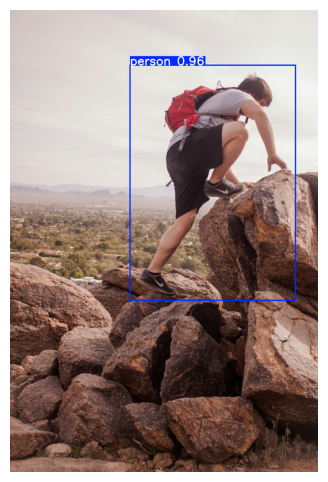

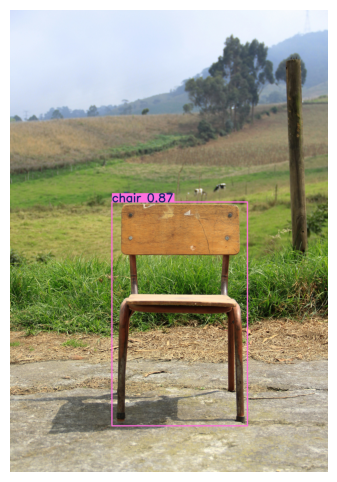

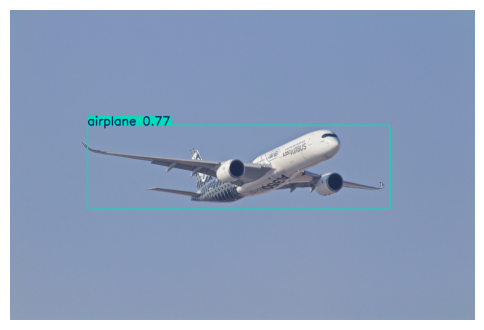

In [22]:

# Create a small folder of sample predictions
SAMPLES_SRC = IMAGES_DIR / "val"
SAMPLES_OUT = RESULTS_DIR / "preds"
SAMPLES_OUT.mkdir(parents=True, exist_ok=True)

pred_model = YOLO(str(weights))
preds = pred_model.predict(source=str(SAMPLES_SRC), save=True, project=str(SAMPLES_OUT), name="images")

# Display a couple of predicted images inline
pred_dir = SAMPLES_OUT / "images"
pred_imgs = list(pred_dir.rglob("*.*"))
for img_path in pred_imgs[:3]:
    img = plt.imread(img_path)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


## 9) Export model to ONNX (Optional)

In [23]:

# Export to ONNX for serving / acceleration
exp = YOLO(str(weights)).export(format="onnx")
print("Exported:", exp)


Ultralytics 8.3.176  Python-3.10.0 torch-2.5.1+cu121 CPU (Intel Core(TM) i7-8700 3.20GHz)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs

PyTorch: starting from 'results\train_aug\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 11, 8400) (21.5 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.64...
ONNX: export success  4.2s, saved as 'results\train_aug\weights\best.onnx' (42.7 MB)

Export complete (6.0s)
Results saved to E:\my_project\Object Detection\results\train_aug\weights
Predict:         yolo predict task=detect model=results\train_aug\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=results\train_aug\weights\best.onnx imgsz=640 data=configs/data.yaml  
Visualize:       https://netron.app
Exported: results\train_aug\weights\best.onnx


## 10) Real-Time Predictions

In [ ]:
!yolo predict model=results/train_aug/weights/best.pt source=./sample/video.mp4 save=True

Ultralytics 8.3.176  Python-3.10.0 torch-2.5.1+cu121 CPU (Intel Core(TM) i7-8700 3.20GHz)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs

video 1/1 (frame 1/485) e:\my_project\Object Detection\sample\video.mp4: 384x640 14 persons, 169.9ms
video 1/1 (frame 2/485) e:\my_project\Object Detection\sample\video.mp4: 384x640 18 persons, 89.5ms
video 1/1 (frame 3/485) e:\my_project\Object Detection\sample\video.mp4: 384x640 14 persons, 91.0ms
video 1/1 (frame 4/485) e:\my_project\Object Detection\sample\video.mp4: 384x640 12 persons, 91.5ms
video 1/1 (frame 5/485) e:\my_project\Object Detection\sample\video.mp4: 384x640 11 persons, 91.8ms
video 1/1 (frame 6/485) e:\my_project\Object Detection\sample\video.mp4: 384x640 11 persons, 91.7ms
video 1/1 (frame 7/485) e:\my_project\Object Detection\sample\video.mp4: 384x640 14 persons, 92.1ms
video 1/1 (frame 8/485) e:\my_project\Object Detection\sample\video.mp4: 384x640 12 persons, 92.1ms
video 1/1 (frame 9/485) e:

In [31]:
!yolo predict model=results/train_aug/weights/best.pt source=0 show=True

Ultralytics 8.3.176  Python-3.10.0 torch-2.5.1+cu121 CPU (Intel Core(TM) i7-8700 3.20GHz)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs

1/1: 0... Success  (inf frames of shape 640x480 at 30.00 FPS)

0: 480x640 2 persons, 196.8ms
0: 480x640 1 person, 109.9ms
0: 480x640 2 persons, 116.9ms
0: 480x640 2 persons, 109.2ms
0: 480x640 2 persons, 107.3ms
0: 480x640 1 person, 108.4ms
0: 480x640 1 person, 106.1ms
0: 480x640 1 person, 111.0ms
0: 480x640 1 person, 111.4ms
0: 480x640 2 persons, 114.1ms
0: 480x640 3 persons, 111.5ms
0: 480x640 2 persons, 112.9ms
0: 480x640 2 persons, 110.7ms
0: 480x640 1 person, 120.3ms
0: 480x640 2 persons, 120.8ms
0: 480x640 2 persons, 131.8ms
0: 480x640 1 person, 122.7ms
0: 480x640 2 persons, 125.3ms
0: 480x640 2 persons, 119.8ms
0: 480x640 2 persons, 134.9ms
0: 480x640 2 persons, 159.3ms
0: 480x640 2 persons, 136.9ms
0: 480x640 2 persons, 116.0ms
0: 480x640 2 persons, 114.1ms
0: 480x640 2 persons, 129.8ms
0: 480x640 2 persons,